### This scripts takes about 1 1/2 minutes seconds to execute

In [1]:
from tqdm.notebook import tqdm, trange
from importlib import reload
import horseracinglib
reload(horseracinglib)
from horseracinglib import *
pd.options.display.max_columns = None

# Load test data (not seen by models) - Legacy MLR/trivial models

In [2]:
runners = pd.read_csv('data\\runners_test.csv', parse_dates=['meeting_date'], infer_datetime_format=True)
runners.sort_values(by=['race_id', 'runner_id'], inplace=True)
runners.head()

,runner_id,race_id,meeting_date,stall_number,gender,age,trainer_id,trainer_sr,sire_id,sire_sr,dam_id,dam_sr,finpos,win,win_perc,sp,mkt_prob,overage,adj_mkt_prob,blinkers,visor,cheekpieces,tonguetie,entire,gelding,daysLTO,position1,position2,position3,position1_1,position1_2,position1_3,position1_4,position2_1,position2_2,position2_3,position2_4,position3_1,position3_2,position3_3,position3_4
788,696863,500812,2014-02-01,5,G,9,18334,0.131833,57278,0.0,1278305,0.0,4,0,0.173913,1.57,0.636943,1.12057,0.568409,0,0,0,1,0,1,8,1,1,2,1,0,0,0,1,0,0,0,0,1,0,0
1620,760268,500812,2014-02-01,6,G,8,101808,0.095238,51945,0.0,298012,0.0,5,0,0.090909,21.00,0.047619,1.12057,0.042495,1,0,0,0,0,1,8,4,4,0,0,0,0,1,0,0,0,1,0,0,0,0
2452,1430418,500812,2014-02-01,2,G,8,6170,0.127783,10117,0.0,251852,0.0,1,1,0.222222,3.50,0.285714,1.12057,0.254972,0,0,0,0,0,1,47,4,4,1,0,0,0,1,0,0,0,1,1,0,0,0
3039,1453673,500812,2014-02-01,1,G,7,10798,0.137195,133362,0.0,144850,0.0,3,0,0.142857,13.00,0.076923,1.12057,0.068646,0,1,0,0,0,1,15,4,1,4,0,0,0,1,1,0,0,0,0,0,0,1
3669,1494633,500812,2014-02-01,3,G,7,18334,0.131833,458268,0.0,209677,0.0,0,0,0.250000,18.60,0.053763,1.12057,0.047979,0,0,0,0,0,1,12,1,1,4,1,0,0,0,1,0,0,0,0,0,0,1


In [3]:
runners_single_race = runners[runners.race_id == 500812]
runners_single_race

,runner_id,race_id,meeting_date,stall_number,gender,age,trainer_id,trainer_sr,sire_id,sire_sr,dam_id,dam_sr,finpos,win,win_perc,sp,mkt_prob,overage,adj_mkt_prob,blinkers,visor,cheekpieces,tonguetie,entire,gelding,daysLTO,position1,position2,position3,position1_1,position1_2,position1_3,position1_4,position2_1,position2_2,position2_3,position2_4,position3_1,position3_2,position3_3,position3_4
788,696863,500812,2014-02-01,5,G,9,18334,0.131833,57278,0.0,1278305,0.0,4,0,0.173913,1.57,0.636943,1.12057,0.568409,0,0,0,1,0,1,8,1,1,2,1,0,0,0,1,0,0,0,0,1,0,0
1620,760268,500812,2014-02-01,6,G,8,101808,0.095238,51945,0.0,298012,0.0,5,0,0.090909,21.00,0.047619,1.12057,0.042495,1,0,0,0,0,1,8,4,4,0,0,0,0,1,0,0,0,1,0,0,0,0
2452,1430418,500812,2014-02-01,2,G,8,6170,0.127783,10117,0.0,251852,0.0,1,1,0.222222,3.50,0.285714,1.12057,0.254972,0,0,0,0,0,1,47,4,4,1,0,0,0,1,0,0,0,1,1,0,0,0
3039,1453673,500812,2014-02-01,1,G,7,10798,0.137195,133362,0.0,144850,0.0,3,0,0.142857,13.00,0.076923,1.12057,0.068646,0,1,0,0,0,1,15,4,1,4,0,0,0,1,1,0,0,0,0,0,0,1
3669,1494633,500812,2014-02-01,3,G,7,18334,0.131833,458268,0.0,209677,0.0,0,0,0.250000,18.60,0.053763,1.12057,0.047979,0,0,0,0,0,1,12,1,1,4,1,0,0,0,1,0,0,0,0,0,0,1
4239,1531212,500812,2014-02-01,4,G,6,10614,0.054632,260301,0.0,215679,0.0,2,0,0.095238,51.00,0.019608,1.12057,0.017498,0,0,0,0,0,1,10,4,1,4,0,0,0,1,1,0,0,0,0,0,0,1


# Load test data (not seen by models) - New NN models

In [4]:
# note, test data is model-specific

test_data = torch.load('data\\mktprob_test_data.pt')
test_data.runners_wide.head()

mkt_prob                                                    \
stall_number        1         2         3         4         5         6    
race_id                                                                    
500812       -0.419505  1.321967 -0.612674 -0.897558  4.251480 -0.663923   
500813       -0.018508 -0.978520 -0.897558 -0.018508  1.163101 -0.419505   
500814        1.719145 -0.419505  0.607048  1.024086 -0.978520 -0.978520   
500815       -0.302851 -0.134352  0.130433  2.275198 -0.570469 -0.134352   
500816       -0.419505 -0.570469 -0.570469  0.130433  1.024086 -0.570469   

                                                                               \
stall_number        7         8         9         10        11   12   13   14   
race_id                                                                         
500812        0.000000  0.000000  0.000000  0.000000  0.000000  0.0  0.0  0.0   
500813        0.455397 -0.018508 -0.612674 -0.740304  0.329026  0.0  0.0  0.0   
500814       -0.815785 -0.936612 -0.612674  1.024086  0.000000  0.0  0.0  0.0   
500815       -0.302851 -0.815785  0.130433 -0.612674  0.000000  0.0  0.0  0.0   
500816       -0.018508  1.024086 -0.570469 -0.815785 -0.134352  0.0  0.0  0.0   

                        win                                                    \
stall_number   15   16   1    2    3    4    5    6    7    8    9    10   11   
race_id                                                                         
500812        0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
500813        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0   
500814        0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
500815        0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
500816        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0   

                                       
stall_number   12   13   14   15   16  
race_id                                
500812        0.0  0.0  0.0  0.0  0.0  
500813        0.0  0.0  0.0  0.0  0.0  
500814        0.0  0.0  0.0  0.0  0.0  
500815        0.0  0.0  0.0  0.0  0.0  
500816        0.0  0.0  0.0  0.0  0.0

In [5]:
test_data.races.head()

""
race_id
500812
500813
500814
500815
500816


In [6]:
test_data.runners_wide.loc[runners_single_race.race_id.iloc[0], :]

          stall_number
mkt_prob  1              -0.419505
          2               1.321967
          3              -0.612674
          4              -0.897558
          5               4.251480
          6              -0.663923
          7               0.000000
          8               0.000000
          9               0.000000
          10              0.000000
          11              0.000000
          12              0.000000
          13              0.000000
          14              0.000000
          15              0.000000
          16              0.000000
win       1               0.000000
          2               1.000000
          3               0.000000
          4               0.000000
          5               0.000000
          6               0.000000
          7               0.000000
          8               0.000000
          9               0.000000
          10              0.000000
          11              0.000000
          12              0.0000

In [7]:
test_data.races.loc[runners_single_race.race_id.iloc[0], :]

Series([], Name: 500812, dtype: float64)

# Demonstrate calculating model probabilities for single race - Legacy MLR/trivial models

In [8]:
my_multinomial_logit = MultinomialLogitModel('models\\multinomial_logit_coefficients.csv', model_prefix='ML')
display(my_multinomial_logit.model_coefficients)
my_multinomial_logit.calculate_model_probabilities_for_single_race(runners_single_race)

,feature,coefficient
0,age,-0.027801
1,trainer_sr,5.300271
2,daysLTO,-0.000583
3,position1_1,0.548396
4,position1_2,0.539932
5,position1_3,0.324656
6,position1_4,-0.218123
7,position2_1,0.202110
8,position2_2,0.180563
9,position2_3,0.087636


,race_id,runner_id,stall_number,win,mod_prob
788,500812,696863,5,0,0.288915
1620,500812,760268,6,0,0.076942
2452,500812,1430418,2,1,0.109100
3039,500812,1453673,1,0,0.139589
3669,500812,1494633,3,0,0.292526
4239,500812,1531212,4,0,0.092927


In [9]:
my_random_choice = RandomChoiceModel(model_prefix='RC')
my_random_choice.calculate_model_probabilities_for_single_race(runners_single_race)

,race_id,runner_id,stall_number,win,mod_prob
788,500812,696863,5,0,0.074749
1620,500812,760268,6,0,0.247915
2452,500812,1430418,2,1,0.132073
3039,500812,1453673,1,0,0.259879
3669,500812,1494633,3,0,0.119495
4239,500812,1531212,4,0,0.165889


In [10]:
my_favourite_choice = FavouriteChoiceModel(model_prefix='FC')
my_favourite_choice.calculate_model_probabilities_for_single_race(runners_single_race)

,race_id,runner_id,stall_number,win,mod_prob
788,500812,696863,5,0,0.568409
1620,500812,760268,6,0,0.042495
2452,500812,1430418,2,1,0.254972
3039,500812,1453673,1,0,0.068646
3669,500812,1494633,3,0,0.047979
4239,500812,1531212,4,0,0.017498


# Demonstrate calculating model probabilities for single race - New NN models

In [11]:
model_inventory = {}
for model_prefix, model_filename, test_data_filename in [('MP', 'models\\mktprob.pt', 'data\\mktprob_test_data.pt'), ('AO', 'models\\AlunOwen_v3.pt', 'data\\AlunOwen_v3_test_data.pt')]:
    test_data = torch.load(test_data_filename)
    model_inventory[model_prefix] = NeuralNetworkModel(model_filename, test_data, model_prefix)
    display(model_inventory[model_prefix].model_object)
    display(model_inventory[model_prefix].calculate_model_probabilities_for_single_race(runners_single_race))

LinSig(
  (neural_network): Sequential(
    (0): Linear(in_features=16, out_features=16, bias=True)
    (1): Sigmoid()
  )
)

,race_id,runner_id,stall_number,win,mod_prob
788,500812,696863,5,0,0.056734
1620,500812,760268,6,0,0.999943
2452,500812,1430418,2,1,0.009613
3039,500812,1453673,1,0,0.009715
3669,500812,1494633,3,0,1.000000
4239,500812,1531212,4,0,0.001114


MLR(
  (neural_network): Sequential(
    (0): ParsLin()
    (1): Softmax(dim=1)
  )
)

,race_id,runner_id,stall_number,win,mod_prob
788,500812,696863,5,0,0.074371
1620,500812,760268,6,0,0.008496
2452,500812,1430418,2,1,0.629130
3039,500812,1453673,1,0,0.003448
3669,500812,1494633,3,0,0.255919
4239,500812,1531212,4,0,0.003966


# Demonstrate calculating model probabilities for multiple races

In [12]:
my_multinomial_logit.calculate_model_probabilities_for_multiple_races(runners)
my_multinomial_logit.model_probabilities.head()

,race_id,runner_id,stall_number,win,mod_prob
0,500812,696863,5,0,0.288915
1,500812,760268,6,0,0.076942
2,500812,1430418,2,1,0.109100
3,500812,1453673,1,0,0.139589
4,500812,1494633,3,0,0.292526


In [13]:
my_random_choice.calculate_model_probabilities_for_multiple_races(runners)
my_random_choice.model_probabilities.head()

,race_id,runner_id,stall_number,win,mod_prob
0,500812,696863,5,0,0.147637
1,500812,760268,6,0,0.309919
2,500812,1430418,2,1,0.132868
3,500812,1453673,1,0,0.172346
4,500812,1494633,3,0,0.141776


In [14]:
my_favourite_choice.calculate_model_probabilities_for_multiple_races(runners)
my_favourite_choice.model_probabilities.head()

,race_id,runner_id,stall_number,win,mod_prob
0,500812,696863,5,0,0.568409
1,500812,760268,6,0,0.042495
2,500812,1430418,2,1,0.254972
3,500812,1453673,1,0,0.068646
4,500812,1494633,3,0,0.047979


In [15]:
model_inventory['MP'].calculate_model_probabilities_for_multiple_races(runners)
model_inventory['MP'].model_probabilities.head()

,race_id,runner_id,stall_number,win,mod_prob
0,500812,696863,5,0,0.056734
1,500812,760268,6,0,0.999943
2,500812,1430418,2,1,0.009613
3,500812,1453673,1,0,0.009715
4,500812,1494633,3,0,1.000000


In [16]:
model_inventory['AO'].calculate_model_probabilities_for_multiple_races(runners)
model_inventory['AO'].model_probabilities.head()

,race_id,runner_id,stall_number,win,mod_prob
0,500812,696863,5,0,0.074371
1,500812,760268,6,0,0.008496
2,500812,1430418,2,1,0.629130
3,500812,1453673,1,0,0.003448
4,500812,1494633,3,0,0.255919


# Calculate model accuracy

In [17]:
my_multinomial_logit.calculate_model_accuracy(runners)

0.23601555489081663

In [18]:
my_random_choice.calculate_model_accuracy(runners)

0.12772958420580316

In [19]:
my_favourite_choice.calculate_model_accuracy(runners)

0.3640442716123243

In [20]:
model_inventory['MP'].calculate_model_accuracy(runners)

0.12653305414298535

In [21]:
model_inventory['AO'].calculate_model_accuracy(runners)

0.12563565659587198

# Demonstrate probability model assessment

In [22]:
my_model_assessment = ProbabilityModelAssessment([my_multinomial_logit, model_inventory['MP'], model_inventory['AO']], runners[['race_id', 'runner_id', 'stall_number', 'win', 'adj_mkt_prob']])
display(my_model_assessment.assessment)
my_model_assessment.perform_assessment()

,race_id,runner_id,stall_number,win,adj_mkt_prob,ML_mod_prob,MP_mod_prob,AO_mod_prob
0,500812,696863,5,0,0.568409,0.288915,0.056734,0.074371
1,500812,760268,6,0,0.042495,0.076942,0.999943,0.008496
2,500812,1430418,2,1,0.254972,0.109100,0.009613,0.629130
3,500812,1453673,1,0,0.068646,0.139589,0.009715,0.003448
4,500812,1494633,3,0,0.047979,0.292526,1.000000,0.255919
...,...,...,...,...,...,...,...,...
31409,619008,2068719,10,0,0.035416,0.067727,0.108370,0.003520
31410,619008,2072533,3,0,0.039986,0.051757,0.047550,0.002291
31411,619008,2106312,4,0,0.082637,0.071175,0.102026,0.005704
31412,619008,2120288,13,0,0.011100,0.103377,0.003231,0.044254


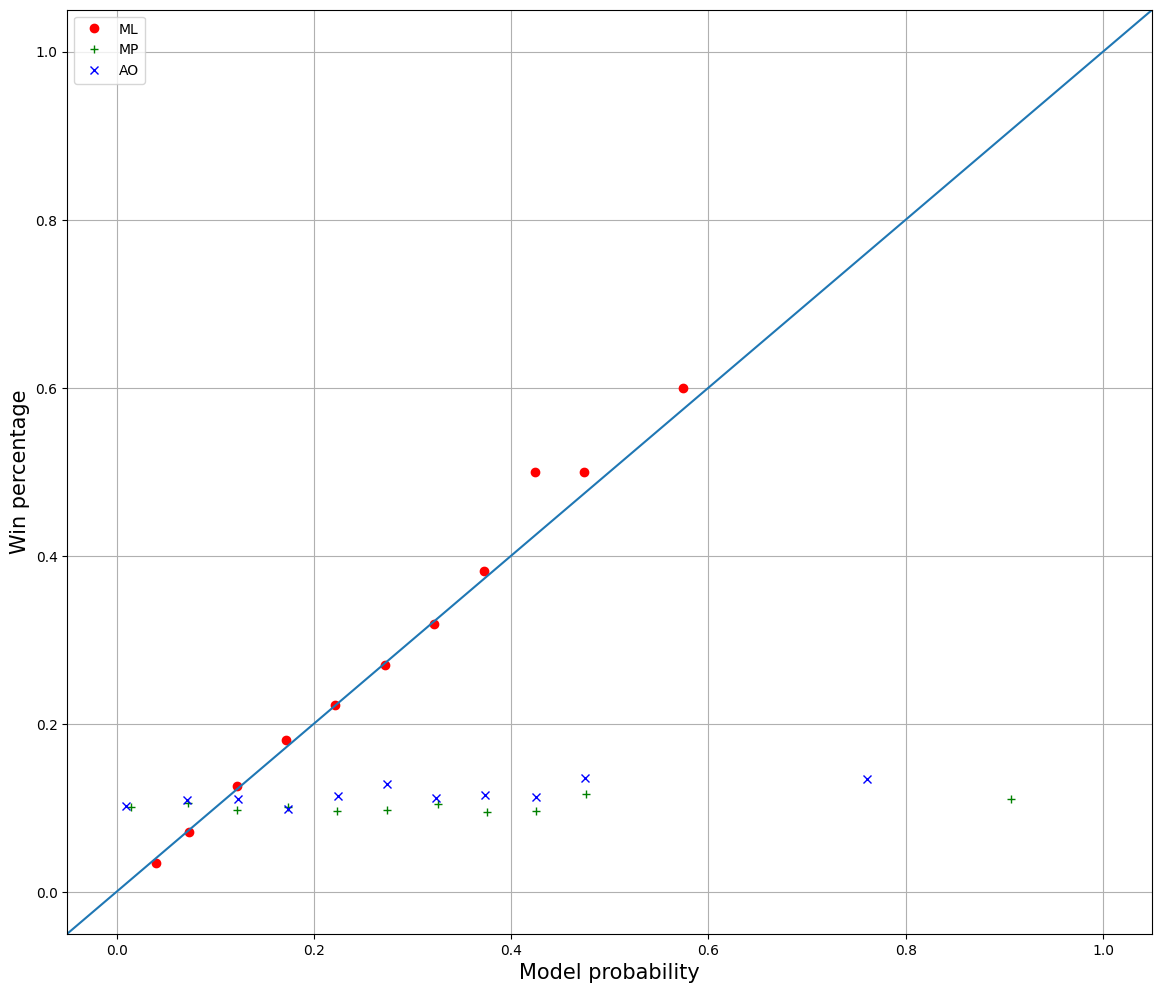

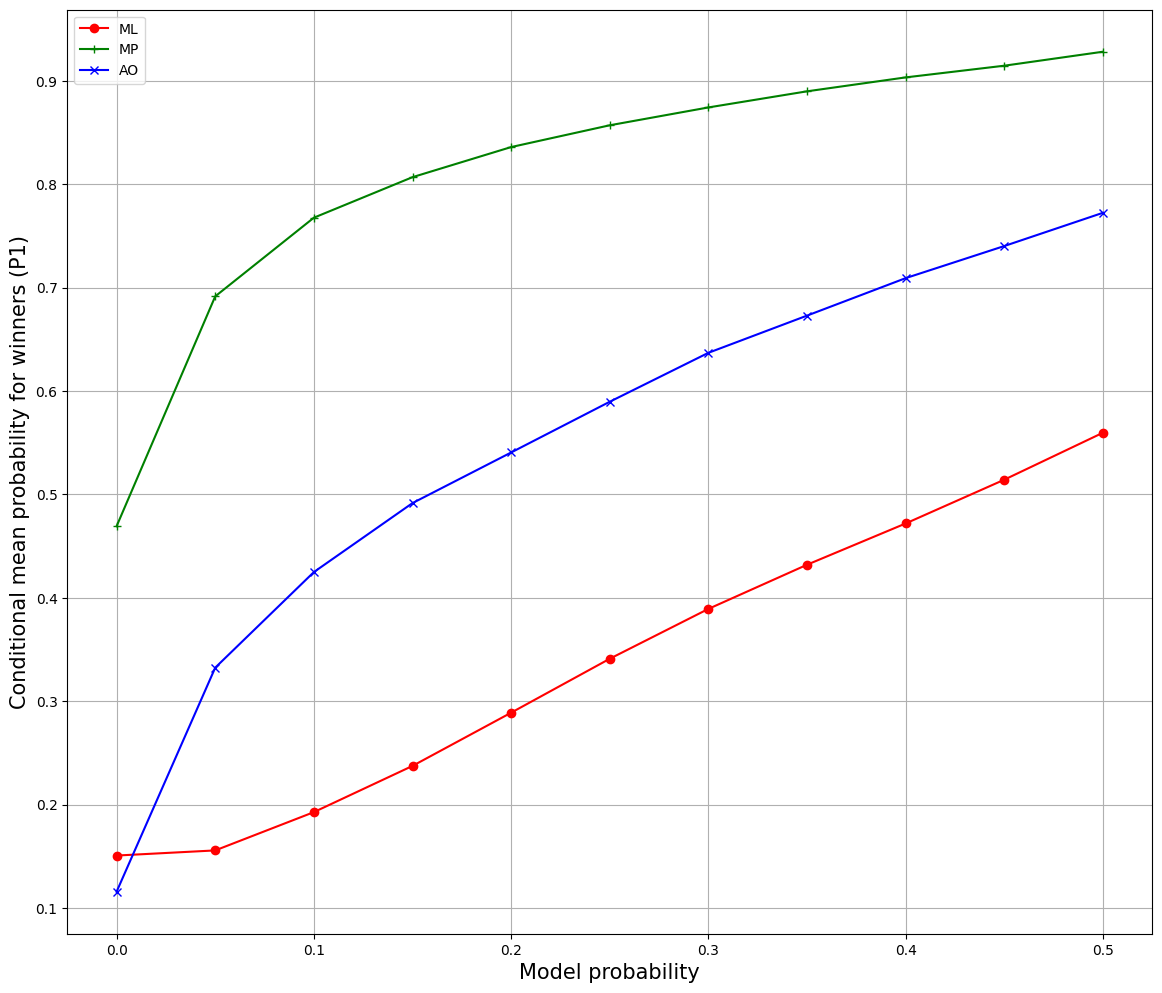

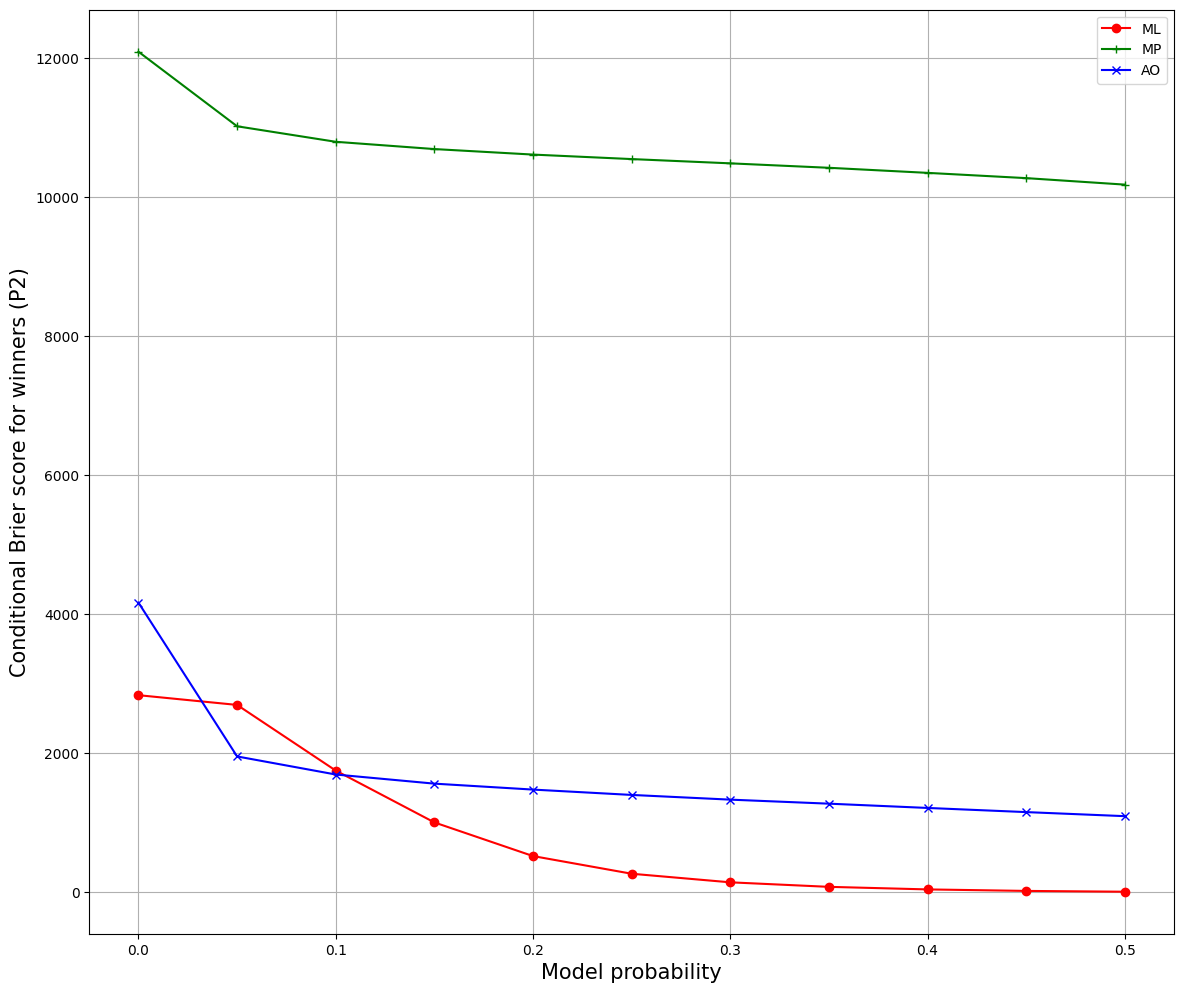

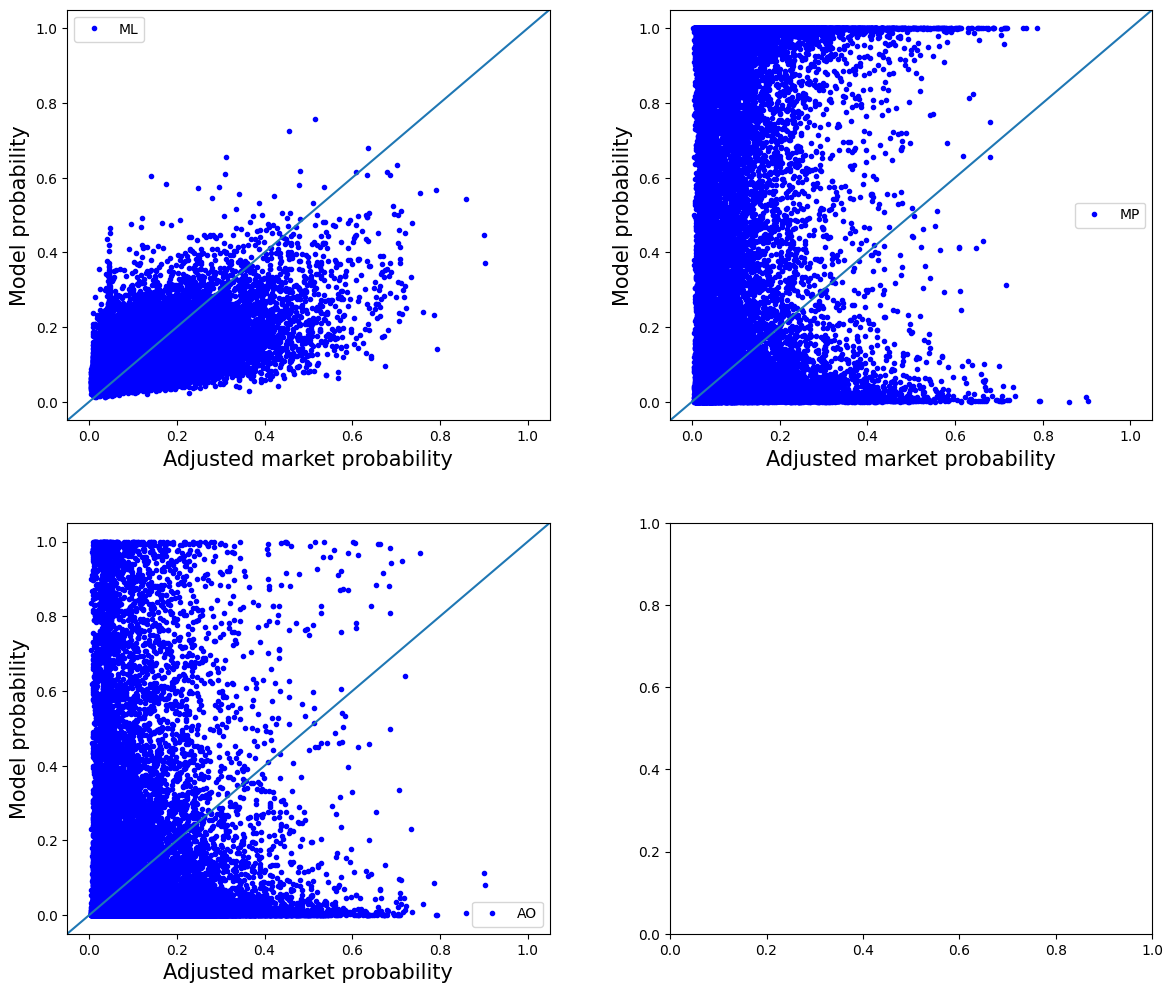

In [23]:
my_model_assessment.show_diagnostic_plots()

# Demonstrate calculating wagering strategy payoffs for single race

In [24]:
def pick_hi_mod_prob(augmented_runners_single_race):
    stakes = pd.Series(np.full(len(augmented_runners_single_race), 0, np.float64), index=augmented_runners_single_race.index)
    max_mod_prob = np.max(augmented_runners_single_race.mod_prob)
    i = augmented_runners_single_race[augmented_runners_single_race.mod_prob == max_mod_prob].index[0]
    stakes[i] = 1
    return stakes

def pick_cond(augmented_runners_single_race):
    return 1 * ((augmented_runners_single_race.mod_prob > 0.15) & (augmented_runners_single_race.mod_prob / augmented_runners_single_race.adj_mkt_prob > 0.13))

In [25]:
my_1st_strategy = WageringStrategy(my_multinomial_logit, pick_hi_mod_prob, 'PickHiModProb')
my_1st_strategy.calculate_strategy_stakes_and_payoffs_for_single_race(runners_single_race)

,race_id,runner_id,stall_number,sp,win,mod_prob,strat_stake,strat_payoff
0,500812,696863,5,1.57,0,0.288915,0.0,0.0
1,500812,760268,6,21.00,0,0.076942,0.0,0.0
2,500812,1430418,2,3.50,1,0.109100,0.0,0.0
3,500812,1453673,1,13.00,0,0.139589,0.0,0.0
4,500812,1494633,3,18.60,0,0.292526,1.0,0.0
5,500812,1531212,4,51.00,0,0.092927,0.0,0.0


In [26]:
my_2nd_strategy = WageringStrategy(model_inventory['MP'], pick_hi_mod_prob, 'PickHiModProb')
my_2nd_strategy.calculate_strategy_stakes_and_payoffs_for_single_race(runners_single_race)

,race_id,runner_id,stall_number,sp,win,mod_prob,strat_stake,strat_payoff
0,500812,696863,5,1.57,0,0.056734,0.0,0.0
1,500812,760268,6,21.00,0,0.999943,0.0,0.0
2,500812,1430418,2,3.50,1,0.009613,0.0,0.0
3,500812,1453673,1,13.00,0,0.009715,0.0,0.0
4,500812,1494633,3,18.60,0,1.000000,1.0,0.0
5,500812,1531212,4,51.00,0,0.001114,0.0,0.0


In [27]:
my_3rd_strategy = WageringStrategy(model_inventory['AO'], pick_hi_mod_prob, 'PickHiModProb')
my_3rd_strategy.calculate_strategy_stakes_and_payoffs_for_single_race(runners_single_race)

,race_id,runner_id,stall_number,sp,win,mod_prob,strat_stake,strat_payoff
0,500812,696863,5,1.57,0,0.074371,0.0,0.0
1,500812,760268,6,21.00,0,0.008496,0.0,0.0
2,500812,1430418,2,3.50,1,0.629130,1.0,3.5
3,500812,1453673,1,13.00,0,0.003448,0.0,0.0
4,500812,1494633,3,18.60,0,0.255919,0.0,0.0
5,500812,1531212,4,51.00,0,0.003966,0.0,0.0


In [28]:
my_4th_strategy = WageringStrategy(my_multinomial_logit, pick_cond, 'PickCond')
my_4th_strategy.calculate_strategy_stakes_and_payoffs_for_single_race(runners_single_race)

,race_id,runner_id,stall_number,sp,win,mod_prob,strat_stake,strat_payoff
0,500812,696863,5,1.57,0,0.288915,1,0.0
1,500812,760268,6,21.00,0,0.076942,0,0.0
2,500812,1430418,2,3.50,1,0.109100,0,0.0
3,500812,1453673,1,13.00,0,0.139589,0,0.0
4,500812,1494633,3,18.60,0,0.292526,1,0.0
5,500812,1531212,4,51.00,0,0.092927,0,0.0


# Demonstrate calculating wagering strategy payoffs for multiple races

In [29]:
my_1st_strategy.calculate_strategy_stakes_and_payoffs_for_multiple_races(runners)
my_1st_strategy.strategy_stakes_and_payoffs.head()

,race_id,runner_id,stall_number,sp,win,mod_prob,strat_stake,strat_payoff
0,500812,696863,5,1.57,0,0.288915,0.0,0.0
1,500812,760268,6,21.00,0,0.076942,0.0,0.0
2,500812,1430418,2,3.50,1,0.109100,0.0,0.0
3,500812,1453673,1,13.00,0,0.139589,0.0,0.0
4,500812,1494633,3,18.60,0,0.292526,1.0,0.0


In [30]:
my_2nd_strategy.calculate_strategy_stakes_and_payoffs_for_multiple_races(runners)
my_2nd_strategy.strategy_stakes_and_payoffs.head()

,race_id,runner_id,stall_number,sp,win,mod_prob,strat_stake,strat_payoff
0,500812,696863,5,1.57,0,0.056734,0.0,0.0
1,500812,760268,6,21.00,0,0.999943,0.0,0.0
2,500812,1430418,2,3.50,1,0.009613,0.0,0.0
3,500812,1453673,1,13.00,0,0.009715,0.0,0.0
4,500812,1494633,3,18.60,0,1.000000,1.0,0.0


In [31]:
my_3rd_strategy.calculate_strategy_stakes_and_payoffs_for_multiple_races(runners)
my_3rd_strategy.strategy_stakes_and_payoffs.head()

,race_id,runner_id,stall_number,sp,win,mod_prob,strat_stake,strat_payoff
0,500812,696863,5,1.57,0,0.074371,0.0,0.0
1,500812,760268,6,21.00,0,0.008496,0.0,0.0
2,500812,1430418,2,3.50,1,0.629130,1.0,3.5
3,500812,1453673,1,13.00,0,0.003448,0.0,0.0
4,500812,1494633,3,18.60,0,0.255919,0.0,0.0


In [32]:
my_4th_strategy.calculate_strategy_stakes_and_payoffs_for_multiple_races(runners)
my_4th_strategy.strategy_stakes_and_payoffs.head()

,race_id,runner_id,stall_number,sp,win,mod_prob,strat_stake,strat_payoff
0,500812,696863,5,1.57,0,0.288915,1,0.0
1,500812,760268,6,21.00,0,0.076942,0,0.0
2,500812,1430418,2,3.50,1,0.109100,0,0.0
3,500812,1453673,1,13.00,0,0.139589,0,0.0
4,500812,1494633,3,18.60,0,0.292526,1,0.0


# Demonstrate wagering strategy assessment

In [33]:
my_strategy_assessment = WageringStrategyAssessment([my_1st_strategy, my_2nd_strategy, my_3rd_strategy, my_4th_strategy], runners[['race_id', 'meeting_date', 'runner_id', 'stall_number', 'win', 'adj_mkt_prob']])
display(my_strategy_assessment.assessment)
my_strategy_assessment.perform_assessment()

,race_id,meeting_date,runner_id,stall_number,win,adj_mkt_prob,PickHiModProb(ML)_mod_prob,PickHiModProb(ML)_strat_stake,PickHiModProb(ML)_strat_payoff,PickHiModProb(MP)_mod_prob,PickHiModProb(MP)_strat_stake,PickHiModProb(MP)_strat_payoff,PickHiModProb(AO)_mod_prob,PickHiModProb(AO)_strat_stake,PickHiModProb(AO)_strat_payoff,PickCond(ML)_mod_prob,PickCond(ML)_strat_stake,PickCond(ML)_strat_payoff
0,500812,2014-02-01,696863,5,0,0.568409,0.288915,0.0,0.0,0.056734,0.0,0.0,0.074371,0.0,0.0,0.288915,1,0.0
1,500812,2014-02-01,760268,6,0,0.042495,0.076942,0.0,0.0,0.999943,0.0,0.0,0.008496,0.0,0.0,0.076942,0,0.0
2,500812,2014-02-01,1430418,2,1,0.254972,0.109100,0.0,0.0,0.009613,0.0,0.0,0.629130,1.0,3.5,0.109100,0,0.0
3,500812,2014-02-01,1453673,1,0,0.068646,0.139589,0.0,0.0,0.009715,0.0,0.0,0.003448,0.0,0.0,0.139589,0,0.0
4,500812,2014-02-01,1494633,3,0,0.047979,0.292526,1.0,0.0,1.000000,1.0,0.0,0.255919,0.0,0.0,0.292526,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31409,619008,2015-10-14,2068719,10,0,0.035416,0.067727,0.0,0.0,0.108370,0.0,0.0,0.003520,0.0,0.0,0.067727,0,0.0
31410,619008,2015-10-14,2072533,3,0,0.039986,0.051757,0.0,0.0,0.047550,0.0,0.0,0.002291,0.0,0.0,0.051757,0,0.0
31411,619008,2015-10-14,2106312,4,0,0.082637,0.071175,0.0,0.0,0.102026,0.0,0.0,0.005704,0.0,0.0,0.071175,0,0.0
31412,619008,2015-10-14,2120288,13,0,0.011100,0.103377,0.0,0.0,0.003231,0.0,0.0,0.044254,0.0,0.0,0.103377,0,0.0


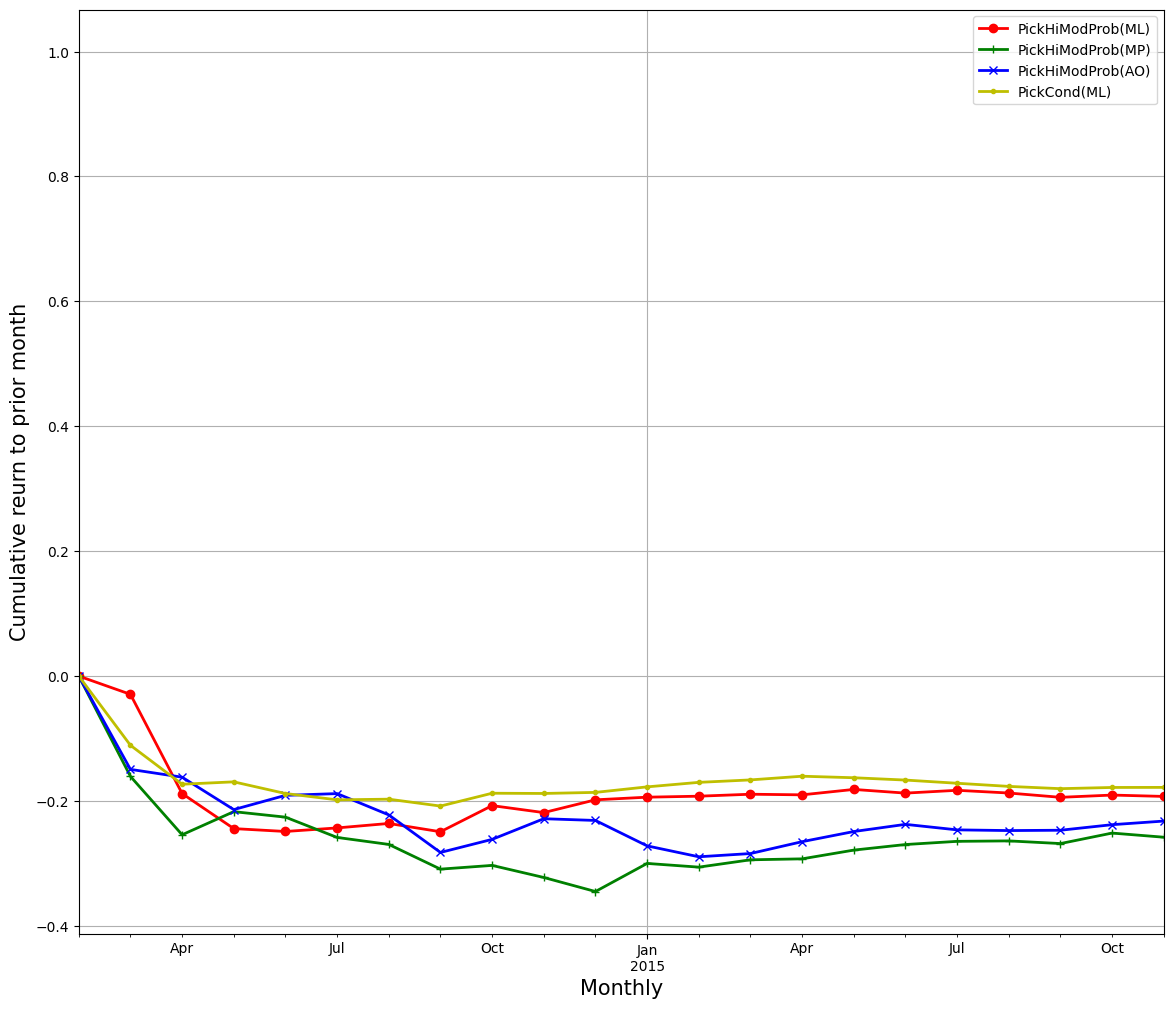

In [34]:
my_strategy_assessment.plot_cumulative_return()

In [35]:
my_strategy_assessment.monthly_assessment['PickHiModProb(ML)']

,as_of,strat_stake,strat_payoff,strat_ret,strat_stake_cumsum,strat_payoff_cumsum,strat_cumret
0,2014-02-01,0.0,0.00,0.000000,0.0,0.00,0.000000
1,2014-03-01,269.0,261.14,-0.029219,269.0,261.14,-0.029219
2,2014-04-01,281.0,185.40,-0.340214,550.0,446.54,-0.188109
3,2014-05-01,197.0,118.05,-0.400761,747.0,564.59,-0.244190
4,2014-06-01,76.0,53.65,-0.294079,823.0,618.24,-0.248797
5,2014-07-01,87.0,70.53,-0.189310,910.0,688.77,-0.243110
6,2014-08-01,81.0,68.39,-0.155679,991.0,757.16,-0.235964
7,2014-09-01,147.0,97.20,-0.338776,1138.0,854.36,-0.249244
8,2014-10-01,153.0,168.89,0.103856,1291.0,1023.25,-0.207397
9,2014-11-01,211.0,150.46,-0.286919,1502.0,1173.71,-0.218569


In [36]:
my_strategy_assessment.monthly_assessment['PickCond(ML)']

,as_of,strat_stake,strat_payoff,strat_ret,strat_stake_cumsum,strat_payoff_cumsum,strat_cumret
0,2014-02-01,0.0,0.00,0.000000,0.0,0.00,0.000000
1,2014-03-01,545.0,484.60,-0.110826,545.0,484.60,-0.110826
2,2014-04-01,637.0,492.73,-0.226484,1182.0,977.33,-0.173156
3,2014-05-01,445.0,374.15,-0.159213,1627.0,1351.48,-0.169342
4,2014-06-01,149.0,90.61,-0.391879,1776.0,1442.09,-0.188012
5,2014-07-01,146.0,99.08,-0.321370,1922.0,1541.17,-0.198143
6,2014-08-01,121.0,99.19,-0.180248,2043.0,1640.36,-0.197083
7,2014-09-01,236.0,164.34,-0.303644,2279.0,1804.70,-0.208118
8,2014-10-01,205.0,213.38,0.040878,2484.0,2018.08,-0.187568
9,2014-11-01,253.0,204.54,-0.191542,2737.0,2222.62,-0.187936
